In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from torchaudio.datasets import SPEECHCOMMANDS

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

Using device: cuda


Classes (35): ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


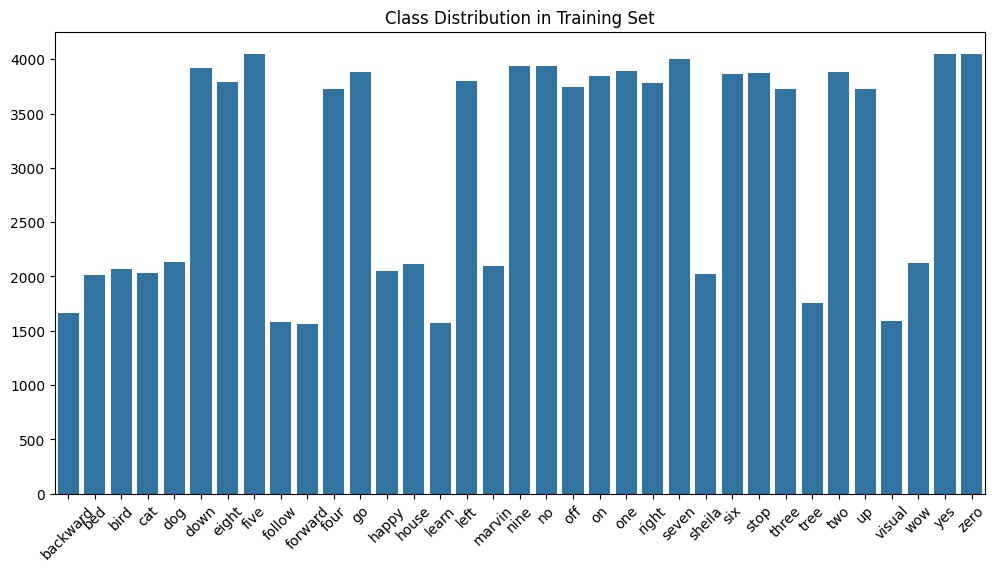

In [3]:
classes = sorted(list(set(dat[2] for dat in train_set)))
num_classes = len(classes)
print(f"Classes ({num_classes}): {classes}")

class_to_idx = {classes[i]: i for i in range(len(classes))}
idx_to_class = {i: classes[i] for i in range(len(classes))}

def plot_class_distribution(dataset, title):
    labels = [data[2] for data in dataset]
    label_counts = {}
    for label in labels:
        label_counts[label] = label_counts.get(label, 0) + 1
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

plot_class_distribution(train_set, "Class Distribution in Training Set")

In [ ]:
def show_waveform(waveform, sample_rate, label=None):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(f"Waveform - {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

def show_spectrogram(spectrogram, label=None):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    plt.title(f"Spectrogram - {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()

import random

num_samples = 3
for i in range(num_samples):
    index = random.randint(0, len(train_set)-1)
    waveform, sample_rate, label, *_ = train_set[index]
    show_waveform(waveform, sample_rate, label)
    spectrogram = T.MelSpectrogram(sample_rate)(waveform)
    show_spectrogram(spectrogram, label)

In [5]:
audio_transforms = {
    'train': nn.Sequential(
        T.MelSpectrogram(sample_rate=16000, n_mels=64),
        T.FrequencyMasking(freq_mask_param=15),
        T.TimeMasking(time_mask_param=35)
    ),
    'val': T.MelSpectrogram(sample_rate=16000, n_mels=64),
    'test': T.MelSpectrogram(sample_rate=16000, n_mels=64)
}

class SpeechCommandsDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.dataset[idx]
        if self.transform:
            spectrogram = self.transform(waveform)
        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = self.class_to_idx[label]
        return spectrogram, label

In [6]:
def collate_fn(batch):
    """
    Pads spectrograms to the same length within a batch.

    Args:
        batch: List of tuples (spectrogram, label)

    Returns:
        features: Tensor of shape (batch_size, 1, n_mels, max_time)
        labels: Tensor of shape (batch_size)
    """
    spectrograms = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])

    max_time = max([spec.shape[-1] for spec in spectrograms])

    padded_specs = []
    for spec in spectrograms:
        pad_amt = max_time - spec.shape[-1]
        spec = F.pad(spec, (0, pad_amt))
        padded_specs.append(spec)

    features = torch.stack(padded_specs)

    return features, labels
train_dataset = SpeechCommandsDataset(train_set, transform=audio_transforms['train'])
val_dataset = SpeechCommandsDataset(val_set, transform=audio_transforms['val'])
test_dataset = SpeechCommandsDataset(test_set, transform=audio_transforms['test'])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

class DeFixMatchModel(nn.Module):
    def __init__(self, num_classes):
        super(DeFixMatchModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (8, 8))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DeFixMatchModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Training Loss: 1.7626, Validation Loss: 0.9340
Epoch 2/10, Training Loss: 1.5472, Validation Loss: 0.7431
Epoch 3/10, Training Loss: 1.4012, Validation Loss: 0.6036
Epoch 4/10, Training Loss: 1.3140, Validation Loss: 0.5491
Epoch 5/10, Training Loss: 1.2375, Validation Loss: 0.4901
Epoch 6/10, Training Loss: 1.1769, Validation Loss: 0.4968
Epoch 7/10, Training Loss: 1.1308, Validation Loss: 0.4497
Epoch 8/10, Training Loss: 1.0905, Validation Loss: 0.4141
Epoch 9/10, Training Loss: 1.0505, Validation Loss: 0.3765
Epoch 10/10, Training Loss: 1.0290, Validation Loss: 0.3582


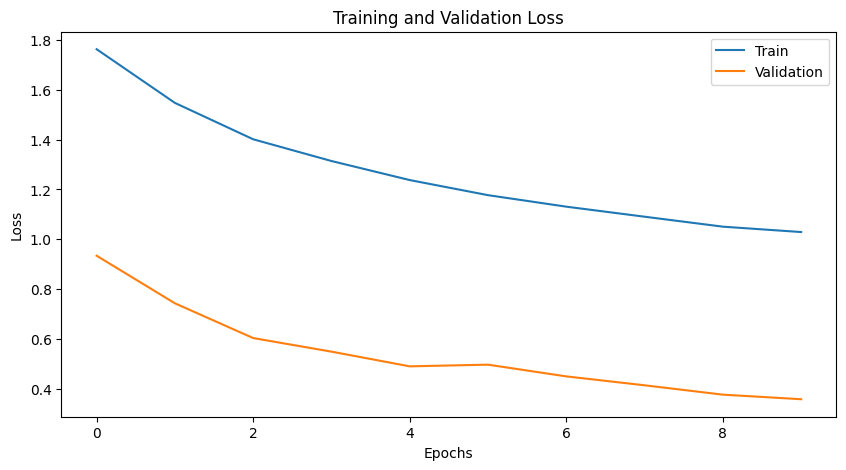

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'GSC_DeFix.pt')

    
    return train_losses, val_losses

epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('GSC_DeFix.pt'))

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()